In [1]:
dataset_dir =r"C:/Users/User/Desktop/rakin2/insulator-segmentation/"
csv_file = '/home/rakin/Desktop/segment/artifacts/train_data.csv'  # Update with the actual path
import os 

In [2]:
imag_dir = os.path.join(dataset_dir,'images/porcelain')
mask_dir = os.path.join(dataset_dir,'mask/porcelain')
print(imag_dir, mask_dir)
print(len(os.listdir(imag_dir)))
print(len(os.listdir(mask_dir)))
assert len(os.listdir(mask_dir)) == len(os.listdir(imag_dir))



C:/Users/User/Desktop/rakin2/insulator-segmentation/images/porcelain C:/Users/User/Desktop/rakin2/insulator-segmentation/mask/porcelain
15759
15759


In [3]:

images_dir_list = []
mask_dir_list = []
for i in os.listdir(imag_dir): 
    images_dir_list.append(os.path.join(imag_dir,i))
    mask_dir_list.append(os.path.join(mask_dir,i))
    


In [4]:
import pandas as pd 
from PIL.Image import open
from torchmetrics.segmentation import MeanIoU , GeneralizedDiceScore 
from torchmetrics.classification import BinaryAccuracy,BinaryJaccardIndex
from Seg.utils.common import read_yaml
from Seg.utils.logger import logger
from tqdm import tqdm
import matplotlib.pyplot as plt 
import torch
import albumentations as A
import numpy as np
import datetime as dt 
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp
from  Seg.components.models import  model_list , R2U_Net,AttU_Net
#config = read_yaml(r"Desktop/segment/config/config.yaml")
date_time = dt.datetime.now().strftime("%Y%m%d-%H%M%S")
logger.info(f"date_time: {date_time}")

# criterion = torch.nn.BCEWithLogitsLoss()
#criterion = torch.nn.CrossEntropyLoss()
criterion = smp.losses.DiceLoss(mode='binary')
# focal loss
#criterion = smp.losses.FocalLoss(mode='binary',gamma=1.0)
IoUScore  = MeanIoU(num_classes = 2).to('cuda')
DiceScore = GeneralizedDiceScore(num_classes=2).to('cuda')
BinaryAccuracy_Score = BinaryAccuracy().to('cuda')
BinaryJaccardIndex_Score = BinaryJaccardIndex().to('cuda')

C:\Users\User\anaconda3\envs\PytorchGPU\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\User\anaconda3\envs\PytorchGPU\lib\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


[2025-03-09 11:27:04,560: INFO: 3804955329: date_time: 20250309-112704]


In [5]:
Train_config = {
  "device" : "cuda",
  "batch_size" : 6,
  "epochs" : 20,
  "lr" : 0.001,
  "loss" : "dice_loss" #dice_loss
}

Model_config = {
    "model_name" : "unet",
    "backbone" : "resnet50", #resnet34
    "weights" : "imagenet",
    "in_channels" : 3 
}

Transform_config = {
    #train transform config 
   "image_size" : 512, 
   "shift_limit" : 0.2,
   "scale_limit" : 0.2,
   "rotate_limit" : 30,
   "ShiftScaleRotate_p" : 0.5, 
   "r_shift_limit" : 25,
   "g_shift_limit" : 25,
   "b_shift_limit" : 25,
   "RGB_Shift_p" : 0.5,
   "brightness_limit" : 0.3, 
   "contrast_limit" : 0.3,
   "RandomBrightnessContrast_p" : 0.5
}
Data_injection = {
    "seed" : 42, 
    "dataset_dir" : "Desktop/rakin2/segment/artifacts/dataset.csv",
    "train_csv_dir" : "Desktop/rakin2/segment/artifacts/train_data.csv",
    "test_csv_dir" : "Desktop/rakin2/segment/artifacts/test_data.csv",
    "val_csv_dir" : "Desktop/rakin2/segment/artifacts/val_data.csv"
}


In [6]:
train_config=Train_config
model_config=Model_config
transform_config=Transform_config
data_injecton_config =Data_injection
logger.info(f"train_config: {train_config}") 
logger.info(f"model_config: {model_config}")
logger.info(f"transform_config: {transform_config}")
logger.info(f"data_injecton_config: {data_injecton_config}")



[2025-03-09 11:27:04,706: INFO: 342151172: train_config: {'device': 'cuda', 'batch_size': 6, 'epochs': 20, 'lr': 0.001, 'loss': 'dice_loss'}]
[2025-03-09 11:27:04,707: INFO: 342151172: model_config: {'model_name': 'unet', 'backbone': 'resnet50', 'weights': 'imagenet', 'in_channels': 3}]
[2025-03-09 11:27:04,708: INFO: 342151172: transform_config: {'image_size': 512, 'shift_limit': 0.2, 'scale_limit': 0.2, 'rotate_limit': 30, 'ShiftScaleRotate_p': 0.5, 'r_shift_limit': 25, 'g_shift_limit': 25, 'b_shift_limit': 25, 'RGB_Shift_p': 0.5, 'brightness_limit': 0.3, 'contrast_limit': 0.3, 'RandomBrightnessContrast_p': 0.5}]
[2025-03-09 11:27:04,710: INFO: 342151172: data_injecton_config: {'seed': 42, 'dataset_dir': 'Desktop/rakin2/segment/artifacts/dataset.csv', 'train_csv_dir': 'Desktop/rakin2/segment/artifacts/train_data.csv', 'test_csv_dir': 'Desktop/rakin2/segment/artifacts/test_data.csv', 'val_csv_dir': 'Desktop/rakin2/segment/artifacts/val_data.csv'}]


(-0.5, 511.5, 511.5, -0.5)

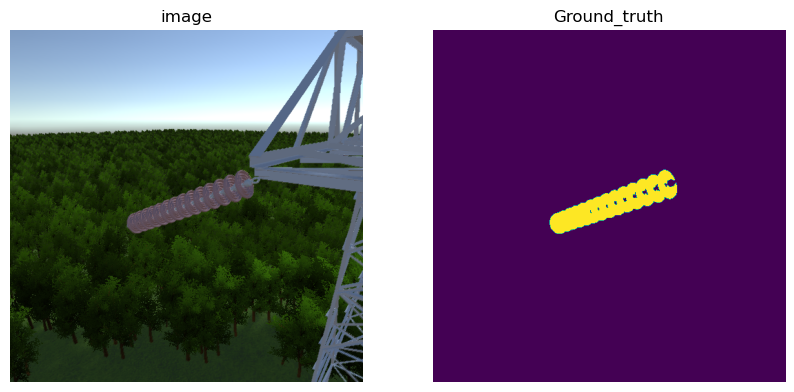

In [7]:


fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,8))
ax1.imshow(open(images_dir_list[2]))
ax1.set_title('image')
ax1.axis('off')
ax2.imshow(open(mask_dir_list[2]))
ax2.set_title('Ground_truth')
ax2.axis('off')


In [8]:
x=pd.DataFrame({'imag_dir_list': images_dir_list , 'mask_dir_list':mask_dir_list})

In [9]:
x.to_csv('dataset.csv')

In [10]:

from PIL import Image
from torch.utils.data import Dataset



class SegmentDataset(Dataset):
    """
    DroneDataset class for loading the dataset with one-hot encoded masks.

    Args:
        img_path: Path to the images directory.
        mask_path: Path to the masks directory.
        X: List of image names.
        transform: Data augmentation transformations.

    Returns:
        image: Image tensor.
        mask: One-hot encoded mask tensor.
    """

    def __init__(self, csv_path , num_classes=2, transform=None):
        self.dataset = pd.read_csv(csv_path)
        self.img_path = self.dataset['imag_dir_list']
        self.mask_path = self.dataset['mask_dir_list']
        self.num_classes = num_classes  # Number of classes for one-hot encoding
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Load image and mask
        image = np.array(Image.open(self.img_path[idx]).convert("RGB"))
        mask = np.array(Image.open(self.mask_path[idx]).convert("L"))  # Grayscale mask

        # Apply Albumentations transformations (if any)
        if self.transform is not None:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        # One-hot encode the mask
        mask_one_hot = np.zeros((mask.shape[0], mask.shape[1], self.num_classes), dtype=np.float32)
        
        # Create one-hot encoding using the unique values in the mask
        for i, unique_value in enumerate(np.unique(mask)):
            mask_one_hot[:, :, i][mask == unique_value] = 1
        
        # Normalize the image using Albumentations Normalize
        norm = A.Normalize(mean=(0 ,0, 0), std=(1, 1, 1))(image=image, mask=mask_one_hot)
        
        # Return image and one-hot encoded mask as tensors in [C, H, W] format
        return norm["image"].transpose(2, 0, 1), norm["mask"].transpose(2, 0, 1).astype("float32")



In [11]:

class DataInjection():
    def __init__(self , Dataset_dir) -> None:
        self.dataset = pd.read_csv(Dataset_dir)
        #self.injection_config = config["Data_injection"]
        

    def inject(self):
        logger.info('data injection started')
        if 'Unnamed: 0' in self.dataset.columns:
            dataset_cleaned = self.dataset.drop(columns=['Unnamed: 0'])
        else:
            dataset_cleaned = self.dataset

        logger.info('train data spliting ')
        train_data, temp_data = train_test_split(dataset_cleaned, test_size=0.2, random_state=42)
        logger.info('val test spliting ')
        val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

        logger.info('csv saving started')   
        train_data.to_csv('train_data.csv', index=False)
        logger.info('train csv done ')
        val_data.to_csv('val_data.csv', index=False)
        logger.info('val csv done ')
        test_data.to_csv('test_data.csv', index=False)
        logger.info('test csv done')


In [12]:
dInj = DataInjection("C:/Users/User/Desktop/rakin2/segment/notebook/dataset.csv")
dInj.inject()

[2025-03-09 11:27:05,279: INFO: 3993860970: data injection started]
[2025-03-09 11:27:05,283: INFO: 3993860970: train data spliting ]
[2025-03-09 11:27:05,285: INFO: 3993860970: val test spliting ]
[2025-03-09 11:27:05,286: INFO: 3993860970: csv saving started]
[2025-03-09 11:27:05,308: INFO: 3993860970: train csv done ]
[2025-03-09 11:27:05,312: INFO: 3993860970: val csv done ]
[2025-03-09 11:27:05,319: INFO: 3993860970: test csv done]


In [13]:



def model_selection(model_name: str, model_encoder: str, weight: str):
    """
    arg:
      model_name(str) name of the model
      model_encoder(str) : name of the encoder used


    return : model object with given encoder

    """

    model = smp.create_model(
        arch=model_name,  # name of the architecture, e.g. 'Unet'/ 'FPN' / etc. Case INsensitive!
        encoder_name=model_encoder,
        encoder_weights=weight,
        in_channels=3,
        classes=2,
    )

    return model



transform = A.Compose([
    A.Resize(transform_config['image_size'], transform_config['image_size']),
    A.RGBShift(r_shift_limit=transform_config['r_shift_limit'], g_shift_limit=transform_config['g_shift_limit'], b_shift_limit=transform_config['b_shift_limit'], p=transform_config['RGB_Shift_p']),
    A.RandomBrightnessContrast(brightness_limit=transform_config['brightness_limit'], contrast_limit=transform_config['contrast_limit'], p=transform_config['RandomBrightnessContrast_p']),
    A.ShiftScaleRotate(shift_limit=transform_config['shift_limit'], scale_limit=transform_config['scale_limit'], rotate_limit=transform_config['rotate_limit'], p=transform_config['ShiftScaleRotate_p'])
    ])
   

In [14]:
model = model_selection(Model_config['model_name'], Model_config['backbone'],Model_config['weights'])
model=model.to('cuda')
#model = AttU_Net(3,2).to('cuda')


In [15]:
Train_DL_config = {
    "train_dirs": "C:/Users/User/Desktop/rakin2/segment/artifacts/train_data.csv",
    "batch_size": 6,
    "num_workers": 4,
    "shuffle": True
}

Val_DL_config = {
    "val_dirs": "C:/Users/User/Desktop/rakin2/segment/artifacts/val_data.csv",
    "batch_size": 2,
    "num_workers": 4,
    "shuffle": False,
    "transform": True,
    "random_blur": False
}

Test_DL_config = {
    # setting to val as test dir is corrupted in local drive
   "test_dirs": "C:/Users/User/Desktop/rakin2/segment/artifacts/test_data.csv",
   "batch_size": 2,
   "num_workers": 4,
   "shuffle": False,
   "transform": True
}

In [17]:

train_data = SegmentDataset(Train_DL_config['train_dirs'],2,transform=transform )
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=Train_DL_config['batch_size'], shuffle=Train_DL_config['shuffle'])
test_data = SegmentDataset(Test_DL_config['test_dirs'],2,transform=transform )
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=Test_DL_config['batch_size'], shuffle=Test_DL_config['shuffle'])
val_data = SegmentDataset(Val_DL_config['val_dirs'],2,transform=transform )
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=Val_DL_config['batch_size'], shuffle=Train_DL_config['shuffle'])

In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr=train_config['lr'])

mean_iou_score_for_training = []
dice_score_for_training =[]
accuracy_for_training = []
train_loss=[]
binary_jaccard_index_for_training = []
dice_coefficient_for_training = []

mean_iou_score = []
dice_score =[]
accuracy = []
val_loss =[]
binary_jaccard_index = []
dice_coefficient = []

for epoch in range(train_config['epochs']):    
    model.train()
    total_losses = 0
    pbar = tqdm(enumerate(train_dataloader), total = len(train_dataloader),colour='green')
    for i, (x, y) in pbar:
        x = x.to('cuda')
        y = y.to('cuda')
        optimizer.zero_grad()
        y_hat = model(x)
        loss = criterion(y_hat,y)
    
        loss.backward()
        optimizer.step()
        total_losses += loss.item()
        jeq_indx_for_training = BinaryJaccardIndex_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        
        mean_miou_for_training = IoUScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        dice_score_values_for_training = DiceScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        acc_for_training = BinaryAccuracy_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        
        mean_iou_score_for_training.append(mean_miou_for_training)
        dice_score_for_training.append(dice_score_values_for_training)
        binary_jaccard_index_for_training.append(jeq_indx_for_training)
        dice_coefficient_for_training.append((2*jeq_indx_for_training*1/(1+jeq_indx_for_training)))
        accuracy_for_training.append(acc_for_training)
        train_loss.append(total_losses/ (i + 1))
        pbar.set_postfix({"epoch": epoch,"train_loss": total_losses / (i + 1) , 
                                  "train_Miou_score": sum(mean_iou_score_for_training)/len(mean_iou_score_for_training) ,
                                    "train_dice_score" : sum(dice_score_for_training)/len(dice_score_for_training),
                                   "train_acc": sum(accuracy_for_training)/len(accuracy_for_training),
                                   "train_binary_jaccard_index": sum(binary_jaccard_index_for_training)/len(binary_jaccard_index_for_training),
                                    "train_dice_coefficient": sum(dice_coefficient_for_training)/len(dice_coefficient_for_training)} )

    # mlflow metrics
    #mlflow.log_metric("train_loss", sum(train_loss) / len(train_loss), step=epoch)
    logger.info(f"Epoch: {epoch} | Training_Loss: {total_losses / len(train_dataloader)}")
    # mlflow metrics
    logger.info(f"train_loss {sum(train_loss) / len(train_loss) }")
    logger.info(f"train_Miou_score {sum(mean_iou_score_for_training)/len(mean_iou_score_for_training)}" )
    logger.info(f"train_dice_score {sum(dice_score_for_training)/len(dice_score_for_training)}" )
    logger.info(f"train_acc {sum(accuracy_for_training)/len(accuracy_for_training)}" )
    logger.info(f"train_binary_jaccard_index: {sum(binary_jaccard_index_for_training)/len(binary_jaccard_index_for_training)}")
    logger.info(f"train_dice_coefficient: {sum(dice_coefficient_for_training)/len(dice_coefficient_for_training)}")

    IoUScore.reset()
    DiceScore.reset()
    BinaryAccuracy_Score.reset()
    BinaryJaccardIndex_Score.reset()
    pbar.close()
    
    total_loss = 0.0
    model.eval()
 
    pbar = tqdm(enumerate(val_dataloader), total=len(val_dataloader),colour="blue")
    
    for i, (x, y) in pbar:
        x = x.to('cuda')
        y = y.to('cuda')
        y_hat = model(x)
        loss = criterion(y_hat, y)
    
        total_loss += loss.item()
        jeq_indx = BinaryJaccardIndex_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        
        mean_miou=   IoUScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        dice_score_values = DiceScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        acc = BinaryAccuracy_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        mean_iou_score.append(mean_miou)
        dice_coefficient.append((2*jeq_indx*1/(1+jeq_indx)))
        binary_jaccard_index.append(jeq_indx)
        dice_score.append(dice_score_values)
        accuracy.append(acc)
        val_loss.append(total_loss/ (i + 1))
        pbar.set_postfix({"epoch": epoch,"eval_loss": total_loss / (i + 1) , 
                                  "eval_Miou_score": sum(mean_iou_score)/len(mean_iou_score) ,
                                    "eval_dice_score" : sum(dice_score)/len(dice_score),
                                   "eval_acc": sum(accuracy)/len(accuracy),
                                   "eval_binary_jaccard_index": sum(binary_jaccard_index)/len(binary_jaccard_index),
                                     "eval_dice_coefficient": sum(dice_coefficient)/len(dice_coefficient)} )
        
        #save model  if val loss is minimum
        
        

    #torch.save(model.state_dict(), f'C:/Users/User/Desktop/rakin/segment/artifacts/model_ckpt/unet_{date_time}.pth')
    
    logger.info(f"Epoch: {epoch} | Loss: {total_loss / len(val_dataloader)}")
    # mlflow metrics
    logger.info(f"eval_loss {sum(val_loss) / len(val_loss) }")
    logger.info(f"eval_Miou_score {sum(mean_iou_score)/len(mean_iou_score)}" )
    logger.info(f"eval_dice_score {sum(dice_score)/len(dice_score)}" )
    logger.info(f"eval_acc {sum(accuracy)/len(accuracy)}" )
    logger.info(f"eval_binary_jaccard_index: {sum(binary_jaccard_index)/len(binary_jaccard_index)}")
    logger.info(f"eval_dice_coefficient: {sum(dice_coefficient)/len(dice_coefficient)}")
    
    IoUScore.reset()
    DiceScore.reset()
    BinaryAccuracy_Score.reset()
    BinaryJaccardIndex_Score.reset()
    pbar.close()

100%|██████████| 2102/2102 [10:26<00:00,  3.36it/s, epoch=0, train_loss=0.0223, train_Miou_score=0.33, train_dice_score=0.704, train_acc=0.983, train_binary_jaccard_index=0.809, train_dice_coefficient=0.884] 

[2025-03-09 11:40:18,597: INFO: 2273413975: Epoch: 0 | Training_Loss: 0.02227753559597099]
[2025-03-09 11:40:18,598: INFO: 2273413975: train_loss 0.054279338239068914]
[2025-03-09 11:40:18,601: INFO: 2273413975: train_Miou_score 0.32992288467787084]
[2025-03-09 11:40:18,603: INFO: 2273413975: train_dice_score 0.7036351971955196]
[2025-03-09 11:40:18,604: INFO: 2273413975: train_acc 0.9833989851991979]
[2025-03-09 11:40:18,606: INFO: 2273413975: train_binary_jaccard_index: 0.8086020056739606]
[2025-03-09 11:40:18,608: INFO: 2273413975: train_dice_coefficient: 0.8843712071647412]



100%|██████████| 788/788 [01:25<00:00,  9.26it/s, epoch=0, eval_loss=0.015, eval_Miou_score=0.339, eval_dice_score=0.752, eval_acc=0.985, eval_binary_jaccard_index=0.84, eval_dice_coefficient=0.897]  

[2025-03-09 11:41:43,755: INFO: 2273413975: Epoch: 0 | Loss: 0.01503425541565503]
[2025-03-09 11:41:43,756: INFO: 2273413975: eval_loss 0.014059918143630702]
[2025-03-09 11:41:43,757: INFO: 2273413975: eval_Miou_score 0.33941666693556677]
[2025-03-09 11:41:43,757: INFO: 2273413975: eval_dice_score 0.7522187564199374]
[2025-03-09 11:41:43,758: INFO: 2273413975: eval_acc 0.9851431072060832]
[2025-03-09 11:41:43,759: INFO: 2273413975: eval_binary_jaccard_index: 0.8401740005530587]
[2025-03-09 11:41:43,759: INFO: 2273413975: eval_dice_coefficient: 0.8967944951449074]



100%|██████████| 2102/2102 [07:49<00:00,  4.48it/s, epoch=1, train_loss=0.0083, train_Miou_score=0.345, train_dice_score=0.747, train_acc=0.988, train_binary_jaccard_index=0.851, train_dice_coefficient=0.912] 

[2025-03-09 11:49:33,242: INFO: 2273413975: Epoch: 1 | Training_Loss: 0.008298753557831304]
[2025-03-09 11:49:33,244: INFO: 2273413975: train_loss 0.031854990589401146]
[2025-03-09 11:49:33,246: INFO: 2273413975: train_Miou_score 0.34510354585520264]
[2025-03-09 11:49:33,247: INFO: 2273413975: train_dice_score 0.7471276440915318]
[2025-03-09 11:49:33,248: INFO: 2273413975: train_acc 0.9876095006626975]
[2025-03-09 11:49:33,249: INFO: 2273413975: train_binary_jaccard_index: 0.8508003313266287]
[2025-03-09 11:49:33,249: INFO: 2273413975: train_dice_coefficient: 0.9120676651157205]



100%|██████████| 788/788 [00:56<00:00, 13.86it/s, epoch=1, eval_loss=0.00922, eval_Miou_score=0.345, eval_dice_score=0.774, eval_acc=0.988, eval_binary_jaccard_index=0.864, eval_dice_coefficient=0.915]

[2025-03-09 11:50:30,105: INFO: 2273413975: Epoch: 1 | Loss: 0.009221945241623118]
[2025-03-09 11:50:30,106: INFO: 2273413975: eval_loss 0.011500012860259007]
[2025-03-09 11:50:30,106: INFO: 2273413975: eval_Miou_score 0.34546001209684785]
[2025-03-09 11:50:30,107: INFO: 2273413975: eval_dice_score 0.7736251122719457]
[2025-03-09 11:50:30,107: INFO: 2273413975: eval_acc 0.9881755809493477]
[2025-03-09 11:50:30,108: INFO: 2273413975: eval_binary_jaccard_index: 0.8635376079574104]
[2025-03-09 11:50:30,109: INFO: 2273413975: eval_dice_coefficient: 0.9148770555337431]



100%|██████████| 2102/2102 [08:06<00:00,  4.32it/s, epoch=2, train_loss=0.00682, train_Miou_score=0.352, train_dice_score=0.768, train_acc=0.989, train_binary_jaccard_index=0.871, train_dice_coefficient=0.925]

[2025-03-09 11:58:37,029: INFO: 2273413975: Epoch: 2 | Training_Loss: 0.006819124538256485]
[2025-03-09 11:58:37,030: INFO: 2273413975: train_loss 0.02366806668114007]
[2025-03-09 11:58:37,031: INFO: 2273413975: train_Miou_score 0.35180338785463466]
[2025-03-09 11:58:37,032: INFO: 2273413975: train_dice_score 0.7678757659245998]
[2025-03-09 11:58:37,033: INFO: 2273413975: train_acc 0.9894873569342888]
[2025-03-09 11:58:37,034: INFO: 2273413975: train_binary_jaccard_index: 0.8710046859598097]
[2025-03-09 11:58:37,034: INFO: 2273413975: train_dice_coefficient: 0.9250456916782542]



100%|██████████| 788/788 [00:52<00:00, 14.87it/s, epoch=2, eval_loss=0.0169, eval_Miou_score=0.353, eval_dice_score=0.784, eval_acc=0.987, eval_binary_jaccard_index=0.872, eval_dice_coefficient=0.918]

[2025-03-09 11:59:30,014: INFO: 2273413975: Epoch: 2 | Loss: 0.016883205036221424]
[2025-03-09 11:59:30,015: INFO: 2273413975: eval_loss 0.012572000507702144]
[2025-03-09 11:59:30,016: INFO: 2273413975: eval_Miou_score 0.3527891680138507]
[2025-03-09 11:59:30,017: INFO: 2273413975: eval_dice_score 0.7836685781960033]
[2025-03-09 11:59:30,017: INFO: 2273413975: eval_acc 0.9865047491948213]
[2025-03-09 11:59:30,018: INFO: 2273413975: eval_binary_jaccard_index: 0.8718641492890354]
[2025-03-09 11:59:30,019: INFO: 2273413975: eval_dice_coefficient: 0.9180925055446205]



100%|██████████| 2102/2102 [07:35<00:00,  4.61it/s, epoch=3, train_loss=0.00548, train_Miou_score=0.357, train_dice_score=0.782, train_acc=0.991, train_binary_jaccard_index=0.885, train_dice_coefficient=0.934]

[2025-03-09 12:07:05,565: INFO: 2273413975: Epoch: 3 | Training_Loss: 0.005477668045817048]
[2025-03-09 12:07:05,567: INFO: 2273413975: train_loss 0.01910969222498709]
[2025-03-09 12:07:05,568: INFO: 2273413975: train_Miou_score 0.35683859429090903]
[2025-03-09 12:07:05,569: INFO: 2273413975: train_dice_score 0.7819263828564661]
[2025-03-09 12:07:05,570: INFO: 2273413975: train_acc 0.9907542899406943]
[2025-03-09 12:07:05,571: INFO: 2273413975: train_binary_jaccard_index: 0.88490182481357]
[2025-03-09 12:07:05,572: INFO: 2273413975: train_dice_coefficient: 0.9336782065681015]



100%|██████████| 788/788 [00:52<00:00, 14.88it/s, epoch=3, eval_loss=0.00784, eval_Miou_score=0.358, eval_dice_score=0.796, eval_acc=0.988, eval_binary_jaccard_index=0.885, eval_dice_coefficient=0.927]

[2025-03-09 12:07:58,519: INFO: 2273413975: Epoch: 3 | Loss: 0.007844951400902066]
[2025-03-09 12:07:58,519: INFO: 2273413975: eval_loss 0.011826229826794763]
[2025-03-09 12:07:58,520: INFO: 2273413975: eval_Miou_score 0.35764379997405005]
[2025-03-09 12:07:58,521: INFO: 2273413975: eval_dice_score 0.7960438602168153]
[2025-03-09 12:07:58,522: INFO: 2273413975: eval_acc 0.9879226533289488]
[2025-03-09 12:07:58,523: INFO: 2273413975: eval_binary_jaccard_index: 0.8854002192286127]
[2025-03-09 12:07:58,525: INFO: 2273413975: eval_dice_coefficient: 0.9271189494140702]



100%|██████████| 2102/2102 [07:35<00:00,  4.61it/s, epoch=4, train_loss=0.00503, train_Miou_score=0.36, train_dice_score=0.791, train_acc=0.992, train_binary_jaccard_index=0.894, train_dice_coefficient=0.94]  

[2025-03-09 12:15:34,423: INFO: 2273413975: Epoch: 4 | Training_Loss: 0.005032345099635174]
[2025-03-09 12:15:34,424: INFO: 2273413975: train_loss 0.01629094033480522]
[2025-03-09 12:15:34,424: INFO: 2273413975: train_Miou_score 0.3600498338606559]
[2025-03-09 12:15:34,426: INFO: 2273413975: train_dice_score 0.7905713089290283]
[2025-03-09 12:15:34,426: INFO: 2273413975: train_acc 0.99160295191773]
[2025-03-09 12:15:34,427: INFO: 2273413975: train_binary_jaccard_index: 0.8943190996355238]
[2025-03-09 12:15:34,428: INFO: 2273413975: train_dice_coefficient: 0.9395558548185323]



100%|██████████| 788/788 [00:54<00:00, 14.55it/s, epoch=4, eval_loss=0.00838, eval_Miou_score=0.36, eval_dice_score=0.801, eval_acc=0.989, eval_binary_jaccard_index=0.892, eval_dice_coefficient=0.932] 

[2025-03-09 12:16:28,604: INFO: 2273413975: Epoch: 4 | Loss: 0.008377313386970365]
[2025-03-09 12:16:28,605: INFO: 2273413975: eval_loss 0.011176222389842349]
[2025-03-09 12:16:28,605: INFO: 2273413975: eval_Miou_score 0.3599524871967402]
[2025-03-09 12:16:28,606: INFO: 2273413975: eval_dice_score 0.8013084387767181]
[2025-03-09 12:16:28,606: INFO: 2273413975: eval_acc 0.9886677194972934]
[2025-03-09 12:16:28,607: INFO: 2273413975: eval_binary_jaccard_index: 0.8920064141276544]
[2025-03-09 12:16:28,607: INFO: 2273413975: eval_dice_coefficient: 0.9317514987428024]



100%|██████████| 2102/2102 [07:35<00:00,  4.62it/s, epoch=5, train_loss=0.00473, train_Miou_score=0.362, train_dice_score=0.797, train_acc=0.992, train_binary_jaccard_index=0.901, train_dice_coefficient=0.944]

[2025-03-09 12:24:03,755: INFO: 2273413975: Epoch: 5 | Training_Loss: 0.004731910638192174]
[2025-03-09 12:24:03,756: INFO: 2273413975: train_loss 0.014387898501714487]
[2025-03-09 12:24:03,757: INFO: 2273413975: train_Miou_score 0.3622996726188817]
[2025-03-09 12:24:03,758: INFO: 2273413975: train_dice_score 0.7974383520303812]
[2025-03-09 12:24:03,759: INFO: 2273413975: train_acc 0.992217204389669]
[2025-03-09 12:24:03,759: INFO: 2273413975: train_binary_jaccard_index: 0.9012432684956483]
[2025-03-09 12:24:03,760: INFO: 2273413975: train_dice_coefficient: 0.9438389493155156]



100%|██████████| 788/788 [00:52<00:00, 14.92it/s, epoch=5, eval_loss=0.00654, eval_Miou_score=0.361, eval_dice_score=0.806, eval_acc=0.989, eval_binary_jaccard_index=0.897, eval_dice_coefficient=0.936]

[2025-03-09 12:24:56,571: INFO: 2273413975: Epoch: 5 | Loss: 0.006540666830721241]
[2025-03-09 12:24:56,572: INFO: 2273413975: eval_loss 0.010277732416734856]
[2025-03-09 12:24:56,572: INFO: 2273413975: eval_Miou_score 0.3611637820000603]
[2025-03-09 12:24:56,573: INFO: 2273413975: eval_dice_score 0.8064073661095841]
[2025-03-09 12:24:56,574: INFO: 2273413975: eval_acc 0.9894704649291063]
[2025-03-09 12:24:56,575: INFO: 2273413975: eval_binary_jaccard_index: 0.8970802099486914]
[2025-03-09 12:24:56,575: INFO: 2273413975: eval_dice_coefficient: 0.935515610999835]



100%|██████████| 2102/2102 [07:36<00:00,  4.61it/s, epoch=6, train_loss=0.00416, train_Miou_score=0.365, train_dice_score=0.805, train_acc=0.993, train_binary_jaccard_index=0.907, train_dice_coefficient=0.948]

[2025-03-09 12:32:32,767: INFO: 2273413975: Epoch: 6 | Training_Loss: 0.004156856708136431]
[2025-03-09 12:32:32,768: INFO: 2273413975: train_loss 0.012913147703952525]
[2025-03-09 12:32:32,769: INFO: 2273413975: train_Miou_score 0.3645959289042428]
[2025-03-09 12:32:32,771: INFO: 2273413975: train_dice_score 0.8045074255689582]
[2025-03-09 12:32:32,772: INFO: 2273413975: train_acc 0.9927377334849187]
[2025-03-09 12:32:32,772: INFO: 2273413975: train_binary_jaccard_index: 0.907497596779763]
[2025-03-09 12:32:32,773: INFO: 2273413975: train_dice_coefficient: 0.9476324163621853]



100%|██████████| 788/788 [00:52<00:00, 14.94it/s, epoch=6, eval_loss=0.0101, eval_Miou_score=0.362, eval_dice_score=0.808, eval_acc=0.99, eval_binary_jaccard_index=0.897, eval_dice_coefficient=0.935]  

[2025-03-09 12:33:25,529: INFO: 2273413975: Epoch: 6 | Loss: 0.010132259523808048]
[2025-03-09 12:33:25,530: INFO: 2273413975: eval_loss 0.010238088661593257]
[2025-03-09 12:33:25,530: INFO: 2273413975: eval_Miou_score 0.3616002780143705]
[2025-03-09 12:33:25,531: INFO: 2273413975: eval_dice_score 0.807926249405436]
[2025-03-09 12:33:25,532: INFO: 2273413975: eval_acc 0.9895295529714783]
[2025-03-09 12:33:25,532: INFO: 2273413975: eval_binary_jaccard_index: 0.8968774821831115]
[2025-03-09 12:33:25,533: INFO: 2273413975: eval_dice_coefficient: 0.9354315717076801]



100%|██████████| 2102/2102 [07:36<00:00,  4.60it/s, epoch=7, train_loss=0.00375, train_Miou_score=0.367, train_dice_score=0.811, train_acc=0.993, train_binary_jaccard_index=0.913, train_dice_coefficient=0.951]

[2025-03-09 12:41:02,506: INFO: 2273413975: Epoch: 7 | Training_Loss: 0.0037523249463735594]
[2025-03-09 12:41:02,509: INFO: 2273413975: train_loss 0.011882061130382109]
[2025-03-09 12:41:02,511: INFO: 2273413975: train_Miou_score 0.3665710597243213]
[2025-03-09 12:41:02,511: INFO: 2273413975: train_dice_score 0.8107349290289585]
[2025-03-09 12:41:02,512: INFO: 2273413975: train_acc 0.9931781744667737]
[2025-03-09 12:41:02,513: INFO: 2273413975: train_binary_jaccard_index: 0.9127341924280861]
[2025-03-09 12:41:02,514: INFO: 2273413975: train_dice_coefficient: 0.9507747330952769]



100%|██████████| 788/788 [00:53<00:00, 14.59it/s, epoch=7, eval_loss=0.00693, eval_Miou_score=0.364, eval_dice_score=0.814, eval_acc=0.99, eval_binary_jaccard_index=0.901, eval_dice_coefficient=0.938]

[2025-03-09 12:41:56,514: INFO: 2273413975: Epoch: 7 | Loss: 0.00693411414090752]
[2025-03-09 12:41:56,515: INFO: 2273413975: eval_loss 0.010059732899347478]
[2025-03-09 12:41:56,516: INFO: 2273413975: eval_Miou_score 0.36352178397558]
[2025-03-09 12:41:56,517: INFO: 2273413975: eval_dice_score 0.8135411927677002]
[2025-03-09 12:41:56,518: INFO: 2273413975: eval_acc 0.9899728506954794]
[2025-03-09 12:41:56,519: INFO: 2273413975: eval_binary_jaccard_index: 0.9013370346500441]
[2025-03-09 12:41:56,519: INFO: 2273413975: eval_dice_coefficient: 0.9382042563818684]



100%|██████████| 2102/2102 [07:36<00:00,  4.61it/s, epoch=8, train_loss=0.00409, train_Miou_score=0.368, train_dice_score=0.816, train_acc=0.993, train_binary_jaccard_index=0.916, train_dice_coefficient=0.953]

[2025-03-09 12:49:32,839: INFO: 2273413975: Epoch: 8 | Training_Loss: 0.00408972407045192]
[2025-03-09 12:49:32,840: INFO: 2273413975: train_loss 0.011016323623556172]
[2025-03-09 12:49:32,841: INFO: 2273413975: train_Miou_score 0.36805505021967055]
[2025-03-09 12:49:32,842: INFO: 2273413975: train_dice_score 0.8156249101422831]
[2025-03-09 12:49:32,843: INFO: 2273413975: train_acc 0.9934830288955583]
[2025-03-09 12:49:32,843: INFO: 2273413975: train_binary_jaccard_index: 0.9163638667406016]
[2025-03-09 12:49:32,844: INFO: 2273413975: train_dice_coefficient: 0.9529657360769559]



100%|██████████| 788/788 [00:53<00:00, 14.71it/s, epoch=8, eval_loss=0.00707, eval_Miou_score=0.365, eval_dice_score=0.819, eval_acc=0.99, eval_binary_jaccard_index=0.905, eval_dice_coefficient=0.941]

[2025-03-09 12:50:26,402: INFO: 2273413975: Epoch: 8 | Loss: 0.00707029887867458]
[2025-03-09 12:50:26,403: INFO: 2273413975: eval_loss 0.009677927962700209]
[2025-03-09 12:50:26,404: INFO: 2273413975: eval_Miou_score 0.36529038072340725]
[2025-03-09 12:50:26,405: INFO: 2273413975: eval_dice_score 0.8189521144348177]
[2025-03-09 12:50:26,405: INFO: 2273413975: eval_acc 0.9903024398063578]
[2025-03-09 12:50:26,406: INFO: 2273413975: eval_binary_jaccard_index: 0.9054464472656585]
[2025-03-09 12:50:26,407: INFO: 2273413975: eval_dice_coefficient: 0.9408478721963838]



100%|██████████| 2102/2102 [07:36<00:00,  4.60it/s, epoch=9, train_loss=0.00328, train_Miou_score=0.37, train_dice_score=0.821, train_acc=0.994, train_binary_jaccard_index=0.92, train_dice_coefficient=0.955]  

[2025-03-09 12:58:03,352: INFO: 2273413975: Epoch: 9 | Training_Loss: 0.003284704929074143]
[2025-03-09 12:58:03,353: INFO: 2273413975: train_loss 0.010214158685815421]
[2025-03-09 12:58:03,355: INFO: 2273413975: train_Miou_score 0.3695726289863137]
[2025-03-09 12:58:03,356: INFO: 2273413975: train_dice_score 0.8205343217702165]
[2025-03-09 12:58:03,357: INFO: 2273413975: train_acc 0.9938072578862778]
[2025-03-09 12:58:03,359: INFO: 2273413975: train_binary_jaccard_index: 0.9202025750758291]
[2025-03-09 12:58:03,360: INFO: 2273413975: train_dice_coefficient: 0.9552476738087928]



100%|██████████| 788/788 [00:54<00:00, 14.39it/s, epoch=9, eval_loss=0.00684, eval_Miou_score=0.367, eval_dice_score=0.824, eval_acc=0.991, eval_binary_jaccard_index=0.909, eval_dice_coefficient=0.943]

[2025-03-09 12:58:58,121: INFO: 2273413975: Epoch: 9 | Loss: 0.006836802826315013]
[2025-03-09 12:58:58,121: INFO: 2273413975: eval_loss 0.009418478959906905]
[2025-03-09 12:58:58,122: INFO: 2273413975: eval_Miou_score 0.3668989576494468]
[2025-03-09 12:58:58,122: INFO: 2273413975: eval_dice_score 0.8237156119013824]
[2025-03-09 12:58:58,123: INFO: 2273413975: eval_acc 0.9905898512922567]
[2025-03-09 12:58:58,124: INFO: 2273413975: eval_binary_jaccard_index: 0.9089072838024979]
[2025-03-09 12:58:58,126: INFO: 2273413975: eval_dice_coefficient: 0.9430320847674629]



100%|██████████| 2102/2102 [07:37<00:00,  4.59it/s, epoch=10, train_loss=0.0033, train_Miou_score=0.371, train_dice_score=0.825, train_acc=0.994, train_binary_jaccard_index=0.923, train_dice_coefficient=0.957] 

[2025-03-09 13:06:35,816: INFO: 2273413975: Epoch: 10 | Training_Loss: 0.0033031729830661125]
[2025-03-09 13:06:35,817: INFO: 2273413975: train_loss 0.009578717230756584]
[2025-03-09 13:06:35,818: INFO: 2273413975: train_Miou_score 0.3707553588705238]
[2025-03-09 13:06:35,818: INFO: 2273413975: train_dice_score 0.8248600796648358]
[2025-03-09 13:06:35,819: INFO: 2273413975: train_acc 0.9940707535105855]
[2025-03-09 13:06:35,820: INFO: 2273413975: train_binary_jaccard_index: 0.9233821619488283]
[2025-03-09 13:06:35,821: INFO: 2273413975: train_dice_coefficient: 0.9571354632582476]



100%|██████████| 788/788 [00:54<00:00, 14.41it/s, epoch=10, eval_loss=0.0106, eval_Miou_score=0.368, eval_dice_score=0.828, eval_acc=0.99, eval_binary_jaccard_index=0.911, eval_dice_coefficient=0.944] 

[2025-03-09 13:07:30,519: INFO: 2273413975: Epoch: 10 | Loss: 0.010566657796729035]
[2025-03-09 13:07:30,520: INFO: 2273413975: eval_loss 0.010038167786157957]
[2025-03-09 13:07:30,521: INFO: 2273413975: eval_Miou_score 0.3683468244813944]
[2025-03-09 13:07:30,521: INFO: 2273413975: eval_dice_score 0.8275872499613353]
[2025-03-09 13:07:30,522: INFO: 2273413975: eval_acc 0.9904852894852114]
[2025-03-09 13:07:30,523: INFO: 2273413975: eval_binary_jaccard_index: 0.9112043182289741]
[2025-03-09 13:07:30,524: INFO: 2273413975: eval_dice_coefficient: 0.9442678237873006]



100%|██████████| 2102/2102 [07:37<00:00,  4.59it/s, epoch=11, train_loss=0.00327, train_Miou_score=0.372, train_dice_score=0.828, train_acc=0.994, train_binary_jaccard_index=0.926, train_dice_coefficient=0.959]

[2025-03-09 13:15:08,274: INFO: 2273413975: Epoch: 11 | Training_Loss: 0.0032651518266843004]
[2025-03-09 13:15:08,275: INFO: 2273413975: train_loss 0.009054630392503276]
[2025-03-09 13:15:08,276: INFO: 2273413975: train_Miou_score 0.3718486722237367]
[2025-03-09 13:15:08,277: INFO: 2273413975: train_dice_score 0.8283868089439639]
[2025-03-09 13:15:08,278: INFO: 2273413975: train_acc 0.99429341780404]
[2025-03-09 13:15:08,279: INFO: 2273413975: train_binary_jaccard_index: 0.9260751589064335]
[2025-03-09 13:15:08,279: INFO: 2273413975: train_dice_coefficient: 0.9587362602051894]



100%|██████████| 788/788 [00:54<00:00, 14.35it/s, epoch=11, eval_loss=0.0038, eval_Miou_score=0.369, eval_dice_score=0.831, eval_acc=0.991, eval_binary_jaccard_index=0.914, eval_dice_coefficient=0.946] 

[2025-03-09 13:16:03,190: INFO: 2273413975: Epoch: 11 | Loss: 0.0038015162430438897]
[2025-03-09 13:16:03,192: INFO: 2273413975: eval_loss 0.009499922047709154]
[2025-03-09 13:16:03,193: INFO: 2273413975: eval_Miou_score 0.369219514204147]
[2025-03-09 13:16:03,193: INFO: 2273413975: eval_dice_score 0.8312760819449044]
[2025-03-09 13:16:03,194: INFO: 2273413975: eval_acc 0.9909619700081659]
[2025-03-09 13:16:03,196: INFO: 2273413975: eval_binary_jaccard_index: 0.9144730315191707]
[2025-03-09 13:16:03,197: INFO: 2273413975: eval_dice_coefficient: 0.9464169297142606]



100%|██████████| 2102/2102 [07:37<00:00,  4.59it/s, epoch=12, train_loss=0.00299, train_Miou_score=0.373, train_dice_score=0.832, train_acc=0.995, train_binary_jaccard_index=0.929, train_dice_coefficient=0.96]

[2025-03-09 13:23:40,905: INFO: 2273413975: Epoch: 12 | Training_Loss: 0.002989554694445217]
[2025-03-09 13:23:40,906: INFO: 2273413975: train_loss 0.008566965545209412]
[2025-03-09 13:23:40,907: INFO: 2273413975: train_Miou_score 0.3728133747671112]
[2025-03-09 13:23:40,909: INFO: 2273413975: train_dice_score 0.831805819939225]
[2025-03-09 13:23:40,910: INFO: 2273413975: train_acc 0.9945030591218806]
[2025-03-09 13:23:40,911: INFO: 2273413975: train_binary_jaccard_index: 0.9285896133540401]
[2025-03-09 13:23:40,912: INFO: 2273413975: train_dice_coefficient: 0.9602150991660672]



100%|██████████| 788/788 [00:54<00:00, 14.38it/s, epoch=12, eval_loss=0.00684, eval_Miou_score=0.37, eval_dice_score=0.833, eval_acc=0.991, eval_binary_jaccard_index=0.916, eval_dice_coefficient=0.947] 

[2025-03-09 13:24:35,702: INFO: 2273413975: Epoch: 12 | Loss: 0.006844682514970073]
[2025-03-09 13:24:35,702: INFO: 2273413975: eval_loss 0.009418476112778367]
[2025-03-09 13:24:35,703: INFO: 2273413975: eval_Miou_score 0.36969371048839234]
[2025-03-09 13:24:35,704: INFO: 2273413975: eval_dice_score 0.8331352549615345]
[2025-03-09 13:24:35,704: INFO: 2273413975: eval_acc 0.9911312600775931]


[2025-03-09 13:24:35,705: INFO: 2273413975: eval_binary_jaccard_index: 0.9160510669676031]
[2025-03-09 13:24:35,705: INFO: 2273413975: eval_dice_coefficient: 0.9474677914405605]


100%|██████████| 2102/2102 [07:37<00:00,  4.60it/s, epoch=13, train_loss=0.00322, train_Miou_score=0.374, train_dice_score=0.835, train_acc=0.995, train_binary_jaccard_index=0.931, train_dice_coefficient=0.961]

[2025-03-09 13:32:13,027: INFO: 2273413975: Epoch: 13 | Training_Loss: 0.0032233907765824945]
[2025-03-09 13:32:13,028: INFO: 2273413975: train_loss 0.008180102084907943]
[2025-03-09 13:32:13,029: INFO: 2273413975: train_Miou_score 0.37359434576213674]
[2025-03-09 13:32:13,030: INFO: 2273413975: train_dice_score 0.8345255913903032]
[2025-03-09 13:32:13,032: INFO: 2273413975: train_acc 0.9946659946872664]
[2025-03-09 13:32:13,033: INFO: 2273413975: train_binary_jaccard_index: 0.9305540649108949]
[2025-03-09 13:32:13,033: INFO: 2273413975: train_dice_coefficient: 0.9613797217644751]



100%|██████████| 788/788 [00:55<00:00, 14.19it/s, epoch=13, eval_loss=0.00999, eval_Miou_score=0.371, eval_dice_score=0.835, eval_acc=0.991, eval_binary_jaccard_index=0.917, eval_dice_coefficient=0.948]

[2025-03-09 13:33:08,559: INFO: 2273413975: Epoch: 13 | Loss: 0.009985295951668987]
[2025-03-09 13:33:08,560: INFO: 2273413975: eval_loss 0.009462647434012046]
[2025-03-09 13:33:08,561: INFO: 2273413975: eval_Miou_score 0.37052280718074543]
[2025-03-09 13:33:08,562: INFO: 2273413975: eval_dice_score 0.8353070216084981]
[2025-03-09 13:33:08,563: INFO: 2273413975: eval_acc 0.9910518274175852]
[2025-03-09 13:33:08,563: INFO: 2273413975: eval_binary_jaccard_index: 0.9174712754437697]
[2025-03-09 13:33:08,564: INFO: 2273413975: eval_dice_coefficient: 0.9481746113834175]



100%|██████████| 2102/2102 [07:37<00:00,  4.59it/s, epoch=14, train_loss=0.00284, train_Miou_score=0.374, train_dice_score=0.837, train_acc=0.995, train_binary_jaccard_index=0.933, train_dice_coefficient=0.963]

[2025-03-09 13:40:46,468: INFO: 2273413975: Epoch: 14 | Training_Loss: 0.0028414613966937295]
[2025-03-09 13:40:46,469: INFO: 2273413975: train_loss 0.0078062926770265575]
[2025-03-09 13:40:46,470: INFO: 2273413975: train_Miou_score 0.3743205442074704]
[2025-03-09 13:40:46,471: INFO: 2273413975: train_dice_score 0.8373645893604839]
[2025-03-09 13:40:46,472: INFO: 2273413975: train_acc 0.9948326047189721]
[2025-03-09 13:40:46,473: INFO: 2273413975: train_binary_jaccard_index: 0.9325445858515324]
[2025-03-09 13:40:46,473: INFO: 2273413975: train_dice_coefficient: 0.962544833548113]



100%|██████████| 788/788 [00:55<00:00, 14.23it/s, epoch=14, eval_loss=0.00907, eval_Miou_score=0.371, eval_dice_score=0.837, eval_acc=0.991, eval_binary_jaccard_index=0.918, eval_dice_coefficient=0.949]

[2025-03-09 13:41:41,836: INFO: 2273413975: Epoch: 14 | Loss: 0.009071283382812732]
[2025-03-09 13:41:41,837: INFO: 2273413975: eval_loss 0.009359584954056881]
[2025-03-09 13:41:41,838: INFO: 2273413975: eval_Miou_score 0.37110143905878223]
[2025-03-09 13:41:41,838: INFO: 2273413975: eval_dice_score 0.8371666859917724]
[2025-03-09 13:41:41,839: INFO: 2273413975: eval_acc 0.9910440402991074]
[2025-03-09 13:41:41,840: INFO: 2273413975: eval_binary_jaccard_index: 0.918277928602918]
[2025-03-09 13:41:41,840: INFO: 2273413975: eval_dice_coefficient: 0.9485253617081774]



100%|██████████| 2102/2102 [07:39<00:00,  4.58it/s, epoch=15, train_loss=0.00275, train_Miou_score=0.375, train_dice_score=0.84, train_acc=0.995, train_binary_jaccard_index=0.934, train_dice_coefficient=0.964] 

[2025-03-09 13:49:21,246: INFO: 2273413975: Epoch: 15 | Training_Loss: 0.0027455939892697175]
[2025-03-09 13:49:21,247: INFO: 2273413975: train_loss 0.007506727112825042]
[2025-03-09 13:49:21,248: INFO: 2273413975: train_Miou_score 0.37502820490700833]
[2025-03-09 13:49:21,250: INFO: 2273413975: train_dice_score 0.8399189578439015]
[2025-03-09 13:49:21,253: INFO: 2273413975: train_acc 0.9949843506466112]
[2025-03-09 13:49:21,256: INFO: 2273413975: train_binary_jaccard_index: 0.9343810320691606]
[2025-03-09 13:49:21,257: INFO: 2273413975: train_dice_coefficient: 0.9636239942361907]



100%|██████████| 788/788 [00:55<00:00, 14.33it/s, epoch=15, eval_loss=0.0065, eval_Miou_score=0.372, eval_dice_score=0.839, eval_acc=0.991, eval_binary_jaccard_index=0.92, eval_dice_coefficient=0.949]  

[2025-03-09 13:50:16,269: INFO: 2273413975: Epoch: 15 | Loss: 0.006499376620738034]
[2025-03-09 13:50:16,270: INFO: 2273413975: eval_loss 0.009154741319389988]
[2025-03-09 13:50:16,271: INFO: 2273413975: eval_Miou_score 0.37175934028054314]
[2025-03-09 13:50:16,272: INFO: 2273413975: eval_dice_score 0.8386801806311989]
[2025-03-09 13:50:16,273: INFO: 2273413975: eval_acc 0.9911979019339314]
[2025-03-09 13:50:16,274: INFO: 2273413975: eval_binary_jaccard_index: 0.9195483600850622]
[2025-03-09 13:50:16,274: INFO: 2273413975: eval_dice_coefficient: 0.94932148141407]



100%|██████████| 2102/2102 [07:40<00:00,  4.57it/s, epoch=16, train_loss=0.00274, train_Miou_score=0.376, train_dice_score=0.842, train_acc=0.995, train_binary_jaccard_index=0.936, train_dice_coefficient=0.965]

[2025-03-09 13:57:56,480: INFO: 2273413975: Epoch: 16 | Training_Loss: 0.0027354879111590328]
[2025-03-09 13:57:56,481: INFO: 2273413975: train_loss 0.007228510253002978]
[2025-03-09 13:57:56,482: INFO: 2273413975: train_Miou_score 0.3756946974424628]
[2025-03-09 13:57:56,483: INFO: 2273413975: train_dice_score 0.8422558458975113]
[2025-03-09 13:57:56,484: INFO: 2273413975: train_acc 0.9951188146664366]
[2025-03-09 13:57:56,485: INFO: 2273413975: train_binary_jaccard_index: 0.9360318162147042]
[2025-03-09 13:57:56,486: INFO: 2273413975: train_dice_coefficient: 0.9645947364609311]



100%|██████████| 788/788 [00:55<00:00, 14.21it/s, epoch=16, eval_loss=0.00377, eval_Miou_score=0.373, eval_dice_score=0.842, eval_acc=0.991, eval_binary_jaccard_index=0.922, eval_dice_coefficient=0.951]

[2025-03-09 13:58:51,949: INFO: 2273413975: Epoch: 16 | Loss: 0.0037713444172428343]
[2025-03-09 13:58:51,950: INFO: 2273413975: eval_loss 0.008859567492684024]
[2025-03-09 13:58:51,951: INFO: 2273413975: eval_Miou_score 0.3725166508990025]
[2025-03-09 13:58:51,952: INFO: 2273413975: eval_dice_score 0.8415062914066928]
[2025-03-09 13:58:51,953: INFO: 2273413975: eval_acc 0.9914941198258445]
[2025-03-09 13:58:51,953: INFO: 2273413975: eval_binary_jaccard_index: 0.9219877311923572]
[2025-03-09 13:58:51,954: INFO: 2273413975: eval_dice_coefficient: 0.951004258957477]



100%|██████████| 2102/2102 [07:39<00:00,  4.57it/s, epoch=17, train_loss=0.00224, train_Miou_score=0.376, train_dice_score=0.845, train_acc=0.995, train_binary_jaccard_index=0.938, train_dice_coefficient=0.966]

[2025-03-09 14:06:31,813: INFO: 2273413975: Epoch: 17 | Training_Loss: 0.002243895484196584]
[2025-03-09 14:06:31,814: INFO: 2273413975: train_loss 0.006944691661928973]
[2025-03-09 14:06:31,815: INFO: 2273413975: train_Miou_score 0.37638773263100966]
[2025-03-09 14:06:31,816: INFO: 2273413975: train_dice_score 0.8446994783963268]
[2025-03-09 14:06:31,818: INFO: 2273413975: train_acc 0.9952656215206238]
[2025-03-09 14:06:31,819: INFO: 2273413975: train_binary_jaccard_index: 0.9378081747694137]
[2025-03-09 14:06:31,820: INFO: 2273413975: train_dice_coefficient: 0.9656311164500657]



100%|██████████| 788/788 [00:55<00:00, 14.28it/s, epoch=17, eval_loss=0.00446, eval_Miou_score=0.373, eval_dice_score=0.844, eval_acc=0.992, eval_binary_jaccard_index=0.924, eval_dice_coefficient=0.952]

[2025-03-09 14:07:27,005: INFO: 2273413975: Epoch: 17 | Loss: 0.0044582724419947204]
[2025-03-09 14:07:27,006: INFO: 2273413975: eval_loss 0.008640982351711377]
[2025-03-09 14:07:27,006: INFO: 2273413975: eval_Miou_score 0.3731684319347522]
[2025-03-09 14:07:27,007: INFO: 2273413975: eval_dice_score 0.8439715303842347]
[2025-03-09 14:07:27,008: INFO: 2273413975: eval_acc 0.9917193257869198]
[2025-03-09 14:07:27,009: INFO: 2273413975: eval_binary_jaccard_index: 0.9236204062891994]
[2025-03-09 14:07:27,009: INFO: 2273413975: eval_dice_coefficient: 0.9521095204714518]



100%|██████████| 2102/2102 [07:42<00:00,  4.55it/s, epoch=18, train_loss=0.00237, train_Miou_score=0.377, train_dice_score=0.847, train_acc=0.995, train_binary_jaccard_index=0.939, train_dice_coefficient=0.967]

[2025-03-09 14:15:09,295: INFO: 2273413975: Epoch: 18 | Training_Loss: 0.0023654856135117]
[2025-03-09 14:15:09,296: INFO: 2273413975: train_loss 0.006707185982956093]
[2025-03-09 14:15:09,298: INFO: 2273413975: train_Miou_score 0.3768895750991171]
[2025-03-09 14:15:09,299: INFO: 2273413975: train_dice_score 0.8468184871673583]
[2025-03-09 14:15:09,300: INFO: 2273413975: train_acc 0.9953905656061459]
[2025-03-09 14:15:09,301: INFO: 2273413975: train_binary_jaccard_index: 0.939315148642167]
[2025-03-09 14:15:09,302: INFO: 2273413975: train_dice_coefficient: 0.9665101791614401]



100%|██████████| 788/788 [00:55<00:00, 14.31it/s, epoch=18, eval_loss=0.0108, eval_Miou_score=0.373, eval_dice_score=0.845, eval_acc=0.992, eval_binary_jaccard_index=0.924, eval_dice_coefficient=0.952] 

[2025-03-09 14:16:04,386: INFO: 2273413975: Epoch: 18 | Loss: 0.010785162146321407]
[2025-03-09 14:16:04,387: INFO: 2273413975: eval_loss 0.008617555582278528]
[2025-03-09 14:16:04,387: INFO: 2273413975: eval_Miou_score 0.37345649249906565]
[2025-03-09 14:16:04,388: INFO: 2273413975: eval_dice_score 0.8446635218099122]
[2025-03-09 14:16:04,389: INFO: 2273413975: eval_acc 0.9915876819142804]
[2025-03-09 14:16:04,390: INFO: 2273413975: eval_binary_jaccard_index: 0.9235113713742392]
[2025-03-09 14:16:04,391: INFO: 2273413975: eval_dice_coefficient: 0.9519080002613483]



100%|██████████| 2102/2102 [07:42<00:00,  4.55it/s, epoch=19, train_loss=0.00275, train_Miou_score=0.377, train_dice_score=0.849, train_acc=0.995, train_binary_jaccard_index=0.94, train_dice_coefficient=0.967]

[2025-03-09 14:23:46,657: INFO: 2273413975: Epoch: 19 | Training_Loss: 0.0027503404698975306]
[2025-03-09 14:23:46,659: INFO: 2273413975: train_loss 0.0065125888495841345]
[2025-03-09 14:23:46,660: INFO: 2273413975: train_Miou_score 0.377410727802781]
[2025-03-09 14:23:46,662: INFO: 2273413975: train_dice_score 0.8485632940032786]
[2025-03-09 14:23:46,663: INFO: 2273413975: train_acc 0.9954837572308067]
[2025-03-09 14:23:46,664: INFO: 2273413975: train_binary_jaccard_index: 0.9404771596660304]
[2025-03-09 14:23:46,666: INFO: 2273413975: train_dice_coefficient: 0.9671878536580598]



100%|██████████| 788/788 [00:54<00:00, 14.36it/s, epoch=19, eval_loss=0.00967, eval_Miou_score=0.374, eval_dice_score=0.846, eval_acc=0.992, eval_binary_jaccard_index=0.924, eval_dice_coefficient=0.952]

[2025-03-09 14:24:41,530: INFO: 2273413975: Epoch: 19 | Loss: 0.009667502593267993]
[2025-03-09 14:24:41,530: INFO: 2273413975: eval_loss 0.008674739554667818]
[2025-03-09 14:24:41,531: INFO: 2273413975: eval_Miou_score 0.3738481055888723]
[2025-03-09 14:24:41,532: INFO: 2273413975: eval_dice_score 0.8461275025294812]
[2025-03-09 14:24:41,533: INFO: 2273413975: eval_acc 0.9915249610310278]
[2025-03-09 14:24:41,534: INFO: 2273413975: eval_binary_jaccard_index: 0.92412356518482]
[2025-03-09 14:24:41,534: INFO: 2273413975: eval_dice_coefficient: 0.9521049597127034]


In [19]:
model.eval()
total_loss = 0.0
jc_score=0.0

pbar = tqdm(enumerate(test_dataloader), total=len(test_dataloader))
IoUScore  = MeanIoU(num_classes = 2).to('cuda')
DiceScore = GeneralizedDiceScore(num_classes=2).to('cuda')
BinaryAccuracy_Score = BinaryAccuracy().to('cuda')
mean_iou_score = []
dice_score =[]
accuracy = []
binary_jaccard_index = []
dice_coefficient = []

with torch.no_grad():
    for i, (x, y) in pbar:
        x = x.to('cuda')
        y = y.to('cuda')

        y_hat = model(x)
        loss = criterion(y_hat, y)
        total_loss += loss.item()
        mean_miou=   IoUScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        jeq_indx = BinaryJaccardIndex_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        dice_score_values = DiceScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        acc = BinaryAccuracy_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        mean_iou_score.append(mean_miou)     
        dice_score.append(dice_score_values)
        binary_jaccard_index.append(jeq_indx)
        dice_coefficient.append((2*jeq_indx*1/(1+jeq_indx)))
        accuracy.append(acc)
        pbar.set_postfix({"loss": total_loss / (i + 1) , 
                        "Miou_score": sum(mean_iou_score)/len(mean_iou_score) ,
                        "dice_score" : sum(dice_score)/len(dice_score), 
                        "acc": sum(accuracy)/len(accuracy),
                        "binary_jaccard_index": sum(binary_jaccard_index)/len(binary_jaccard_index),
                         "dice_coefficient": sum(dice_coefficient)/len(dice_coefficient)})
    
    logger.info(f"Test Loss: {total_loss / len(test_dataloader)}") 
    logger.info(f"Test Miou_score: {sum(mean_iou_score)/len(mean_iou_score)}")
    logger.info(f"Test dice_score: {sum(dice_score)/len(dice_score)}")
    logger.info(f"Test acc: {sum(accuracy)/len(accuracy)}")
    logger.info(f"test_dice_coefficient: {sum(dice_coefficient)/len(dice_coefficient)}")
    logger.info(f"Test binary_jaccard_index: {sum(binary_jaccard_index)/len(binary_jaccard_index)}")
    #mlflow.log_metric("Test_loss", total_loss / len(test_dataloader))
    #mlflow.log_metric("Test_Miou_score", sum(mean_iou_score)/len(mean_iou_score))
    #mlflow.log_metric("Test_dice_score", sum(dice_score)/len(dice_score))
    #mlflow.log_metric("Test_acc", sum(accuracy)/len(accuracy))
    
    print('----------------------------------') 
    pbar.close()
  


100%|██████████| 788/788 [01:22<00:00,  9.60it/s, loss=0.0102, Miou_score=0.383, dice_score=0.878, acc=0.99, binary_jaccard_index=0.936, dice_coefficient=0.956]  

[2025-03-09 14:26:03,657: INFO: 580206084: Test Loss: 0.01019336328591187]


[2025-03-09 14:26:03,659: INFO: 580206084: Test Miou_score: 0.382966308887613]
[2025-03-09 14:26:03,661: INFO: 580206084: Test dice_score: 0.8781253558200628]
[2025-03-09 14:26:03,662: INFO: 580206084: Test acc: 0.9898101375792837]
[2025-03-09 14:26:03,663: INFO: 580206084: test_dice_coefficient: 0.9558525780938657]
[2025-03-09 14:26:03,664: INFO: 580206084: Test binary_jaccard_index: 0.9359793873990739]
----------------------------------


In [20]:
#load model 
#model_path =f'C:/Users/rakin/Desktop/segment/artifacts/model_ckpt/unet_{date_time}.pth'
#model = Att_unet(3,2)
#model = model_selection(model_config['model_name'], model_config['backbone'],model_config['weights'])
#model = model.to("cuda")
#model.load_state_dict(torch.load(model_path))


In [21]:

images, masks = next(iter(test_dataloader))
# test 
for i, (x, y) in pbar:
    x = x.to('cuda')
    y = y.to('cuda')
    y_hat = model(x)
  


(-0.5, 511.5, 511.5, -0.5)

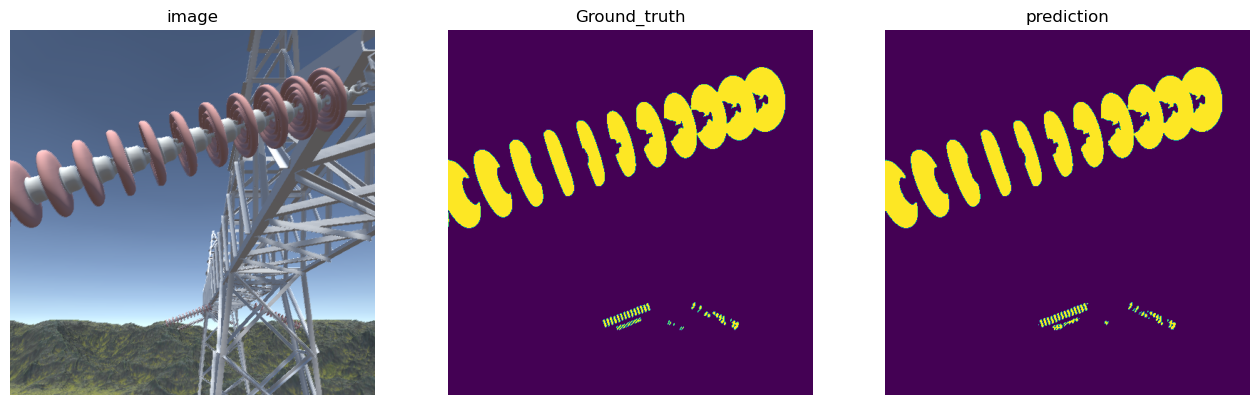

In [22]:
indx = np.random.randint(0, 2)
test_prediction = torch.argmax(y_hat[indx], 0).to('cpu').numpy()
Ground_truth = torch.argmax(y[indx], 0).to('cpu').numpy()
fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(16,9))
ax1.imshow(x[indx].to('cpu').numpy().transpose(1,2,0))
ax1.set_title('image')
ax1.axis('off')
ax2.imshow(Ground_truth)
ax2.set_title('Ground_truth')
ax2.axis('off')
ax3.imshow(test_prediction)
ax3.set_title("prediction")
ax3.axis('off')


In [23]:

torch.save(model.state_dict(), f'C:/Users/User/Desktop/rakin2/segment/artifacts/model_ckpt/unet_resnet50_porcelain.pth')

In [24]:
#load model 
model_path =r'C:/Users/User/Desktop/rakin2/segment/artifacts/model_ckpt/unet_resnet50_porcelain.pth'
model = model_selection(model_config['model_name'], model_config['backbone'],model_config['weights'])
model.load_state_dict(torch.load(model_path))

C:\Users\User\AppData\Local\Temp\ipykernel_11120\1884885147.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [25]:
model.to('cuda')

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [26]:
dir = 'C:/Users/User/Desktop/rakin2/segment/notebook/real_dataset.csv'

In [27]:
transform = A.Compose([
    A.Resize(transform_config['image_size'], transform_config['image_size']),
    # A.RGBShift(r_shift_limit=transform_config['r_shift_limit'], g_shift_limit=transform_config['g_shift_limit'], b_shift_limit=transform_config['b_shift_limit'], p=transform_config['RGB_Shift_p']),
    # A.RandomBrightnessContrast(brightness_limit=transform_config['brightness_limit'], contrast_limit=transform_config['contrast_limit'], p=transform_config['RandomBrightnessContrast_p']),
    # A.ShiftScaleRotate(shift_limit=transform_config['shift_limit'], scale_limit=transform_config['scale_limit'], rotate_limit=transform_config['rotate_limit'], p=transform_config['ShiftScaleRotate_p'])
], is_check_shapes=False)

In [28]:
real_data = SegmentDataset(dir,2,transform=transform )

In [29]:
real_dataloader = torch.utils.data.DataLoader(real_data, batch_size=10, shuffle=True)

In [30]:
#images, masks = next(iter(real_dataloader))

In [31]:
print(f'sahpe of the image {images.shape} and mask {masks.shape} ,images type {type(images)} and mask type {type(masks)}')

sahpe of the image torch.Size([2, 3, 512, 512]) and mask torch.Size([2, 2, 512, 512]) ,images type <class 'torch.Tensor'> and mask type <class 'torch.Tensor'>


In [32]:
#model.eval()
#real_predictions = []

#with torch.no_grad():
    #for images, masks in tqdm(real_dataloader):
        #images = images.to('cuda')
        #masks = masks.to('cuda')
        #outputs = model(images)
        #preds = torch.argmax(outputs, dim=1)
        #0+.
#real_predictions.append(preds.cpu().numpy())


In [33]:
plt.figure(figsize=(16, 16))

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

In [34]:
# import matplotlib.pyplot as plt
# random_indx = np.random.randint(0, 1000)
# Select a random index to visualize
# indx = np.random.randint(0, len(images))

# Get the image, ground truth, and prediction
# image = images[indx].to('cpu').numpy().transpose(1, 2, 0)
# ground_truth = torch.argmax(masks[indx], 0).to('cpu').numpy()
# prediction = torch.argmax(outputs[indx], 0).to('cpu').numpy()

# Plot the image, ground truth, and prediction
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
# ax1.imshow(image)
# ax1.set_title('Image')
# ax1.axis('off')
# ax2.imshow(prediction)
# ax2.set_title('Ground Truth')
# ax2.axis('off')
# plt.savefig(f'prediction{random_indx}.png')
# plt.show()